<a href="https://colab.research.google.com/github/Kiran-Venkatesh/KV/blob/master/Big_Data_Stock_Movement_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

     |████████████████████████████████| 5.5MB 3.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=c26239b4cec9b43bc24918c52275775ba3959981c14112ed4f5a5c88be501afd
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf

data_df = yf.download("AAPL", start="2020-02-01", end="2020-11-02")
data_df=data_df.reset_index()

[*********************100%***********************]  1 of 1 completed


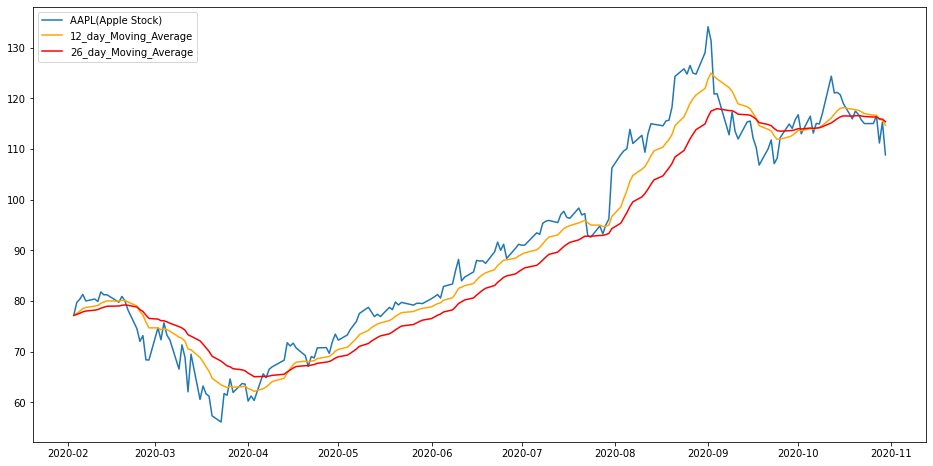

In [ ]:
import matplotlib.pyplot as plt
exp1 = data_df.Close.ewm(span=12, adjust=False).mean()
exp2 = data_df.Close.ewm(span=26, adjust=False).mean()
macd = exp1-exp2
plt.figure(figsize=(16,8))
plt.plot(data_df.Date, data_df.Close, label='AAPL(Apple Stock)')
plt.plot(data_df.Date, exp1, label='12_day_Moving_Average',color="Orange")
plt.plot(data_df.Date, exp2, label='26_day_Moving_Average',color="Red")

plt.legend(loc='upper left')

plt.show()

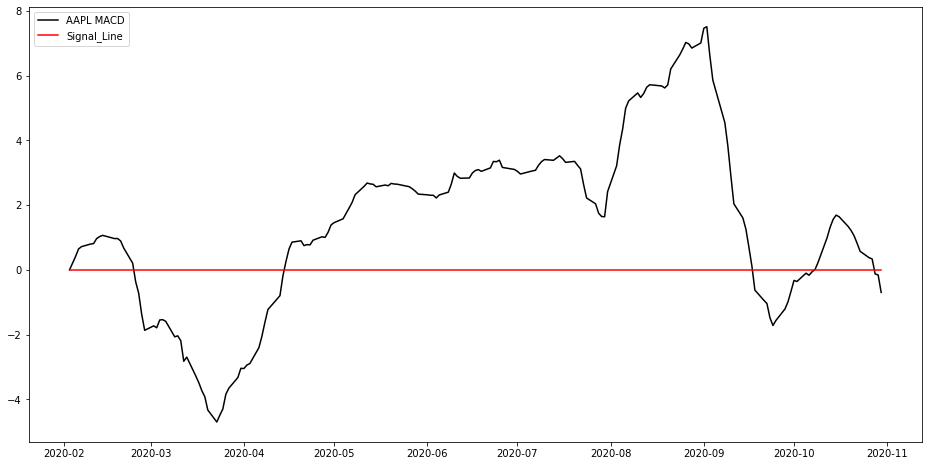

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data_df.Date, macd, label='AAPL MACD', color = 'Black')
plt.plot(data_df.Date, [0]*len(macd),label='Signal_Line',color = 'Red')

plt.legend(loc='upper left')
plt.show()

In [ ]:
data_df['MACD']=macd
data_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MACD
0,2020-02-03,76.074997,78.372498,75.555000,77.165001,76.636299,173985600,0.000000
1,2020-02-04,78.827499,79.910004,78.407501,79.712502,79.166336,136616400,0.203219
2,2020-02-05,80.879997,81.190002,79.737503,80.362503,79.811897,118826800,0.411973
3,2020-02-06,80.642502,81.305000,80.065002,81.302498,80.745445,105425600,0.645817
4,2020-02-07,80.592499,80.849998,79.500000,80.007500,79.647896,117684000,0.718363


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df=spark.createDataFrame(data_df)
df.show()


+-------------------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+-------------------+
|               Date|             Open|             High|              Low|            Close|        Adj Close|   Volume|               MACD|
+-------------------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+-------------------+
|2020-02-03 00:00:00|76.07499694824219|78.37249755859375|75.55500030517578|77.16500091552734|76.63629913330078|173985600|                0.0|
|2020-02-04 00:00:00|78.82749938964844|79.91000366210938|78.40750122070312| 79.7125015258789|79.16633605957031|136616400|0.20321942190840048|
|2020-02-05 00:00:00|80.87999725341797|81.19000244140625|79.73750305175781|80.36250305175781|79.81189727783203|118826800|  0.411973000431999|
|2020-02-06 00:00:00|80.64250183105469|81.30500030517578|80.06500244140625|81.30249786376953|80.74544525146484|105425600| 0.6458168660405192|
|2020-

In [ ]:
L=list(map(lambda x,y: 1 if x.Open-y.Close>0 else 0, df.select('Open').head(df.count())[1:], df.select('Close').head(df.count())[:-1]))
L.append(0)

len(L)

190

In [ ]:
import pandas as pd
data_df["Target"]=pd.DataFrame(L)
df=spark.createDataFrame(data_df)
df.show()

+-------------------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+-------------------+------+
|               Date|             Open|             High|              Low|            Close|        Adj Close|   Volume|               MACD|Target|
+-------------------+-----------------+-----------------+-----------------+-----------------+-----------------+---------+-------------------+------+
|2020-02-03 00:00:00|76.07499694824219|78.37249755859375|75.55500030517578|77.16500091552734|76.63629913330078|173985600|                0.0|     1|
|2020-02-04 00:00:00|78.82749938964844|79.91000366210938|78.40750122070312| 79.7125015258789|79.16633605957031|136616400|0.20321942190840048|     1|
|2020-02-05 00:00:00|80.87999725341797|81.19000244140625|79.73750305175781|80.36250305175781|79.81189727783203|118826800|  0.411973000431999|     1|
|2020-02-06 00:00:00|80.64250183105469|81.30500030517578|80.06500244140625|81.30249786376953|80.7454452514

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['Open','High','Low','Close','MACD'],outputCol="features")
df=assembler.transform(df)


In [ ]:
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
df=standardscaler.fit(df).transform(df)
df.select("features","Scaled_features").show(5)


+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[76.0749969482421...|[3.69428532052585...|
|[78.8274993896484...|[3.82794985909845...|
|[80.8799972534179...|[3.92762140734304...|
|[80.6425018310546...|[3.91608836905550...|
|[80.5924987792968...|[3.91366016599930...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
train_data, test_data = df.randomSplit([.9,.1],seed=1234)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier

#lr = RandomForestClassifier(labelCol="Target", featuresCol="Scaled_features")

lr = LogisticRegression(labelCol="Target", featuresCol="Scaled_features",maxIter=200)
model=lr.fit(train_data)
predict_train=model.transform(train_data)
predict_test=model.transform(test_data)
predict_test.select("Target","prediction").show()
predict_test.show()

+------+----------+
|Target|prediction|
+------+----------+
|     1|       1.0|
|     0|       0.0|
|     0|       1.0|
|     1|       1.0|
|     0|       1.0|
|     0|       1.0|
|     0|       1.0|
|     0|       1.0|
|     1|       1.0|
|     0|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       0.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+

+-------------------+------------------+------------------+------------------+------------------+------------------+---------+-------------------+------+--------------------+--------------------+--------------------+--------------------+----------+
|               Date|              Open|              High|               Low|             Close|         Adj Close|   Volume|               MACD|Target|            features|     Scaled_features|       rawPrediction|         probability|prediction|
+-------------------+------------------+------------------+------------------+------------------+----

In [ ]:
from sklearn.metrics import classification_report
y_true=[int(row.Target) for row in predict_test.select('Target').collect()]
y_pred=[int(row.prediction) for row in predict_test.select('prediction').collect()]
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.57      1.00      0.73         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted avg       0.79      0.62      0.56        16



In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predict_test))

***END***

In [ ]:
list(df.select('Open').show(4)[0])[1:]

+------------------+
|              Open|
+------------------+
| 31.75749969482422|
|  31.9950008392334|
| 32.07749938964844|
|32.282501220703125|
+------------------+
only showing top 4 rows



TypeError: ignored

In [ ]:
df.select('Close').head(df.count())[0][0]

32.1875

In [ ]:
L=[]
for i in range(df.count()):
  c=df.collect()[i+1]['Open']-df.collect()[i]['Close']
  if c>0:
    L.append("Higher")
  else:
    L.append("Lower")



KeyboardInterrupt: ignored

In [ ]:
len(L)

NameError: ignored

In [ ]:
spark.sparkContext.parallelize(L).toDF("id")

936

In [ ]:
from pyspark.sql.functions import udf
F1 = udf(lambda x: '-1' if x in not_found_cat else x, StringType())
df.withColumn('next_day_price_direction', train.Purchase /2.0).select('Open','Close').show(5)

In [ ]:
dd={"root":{"ID":1,"Bal":23}}
import pandas as pd
pd.DataFrame(dd.values())

,ID,Bal
0,1,23


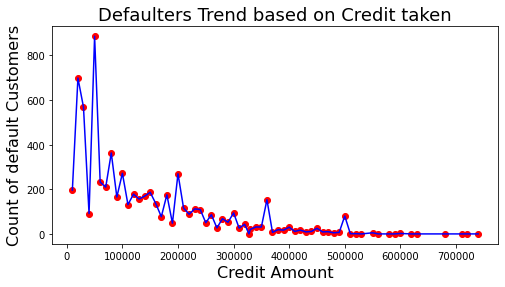

In [ ]:
import matplotlib.pyplot as plt
data=pd.read_csv("/content/UCI_Credit_Card.csv")
deflt=data.loc[data['default.payment.next.month']==1]
risk=pd.DataFrame(deflt.LIMIT_BAL.value_counts()).reset_index()
risk.columns=['LIMIT_BAL','count']
risk=risk.sort_values('LIMIT_BAL')
plt.figure(figsize=(8,4))
plt.scatter(risk['LIMIT_BAL'],risk['count'],color="r")
plt.plot(risk['LIMIT_BAL'],risk['count'],color="blue")
plt.title("Defaulters Trend based on Credit taken",fontsize=18)
plt.xlabel('Credit Amount', fontsize=16)
plt.ylabel('Count of default Customers', fontsize=16)

plt.show()

In [ ]:
pip install xmltodict


In [ ]:
import pandas as pd

import xmltodict
  
xml='''<?xml version='1.0' encoding='utf-8'?><root><Result>Will default next month, Suggestion is Tier 1 - Low Risk</Result><Probability>0.32694152741967175</Probability></root>'''
pd.DataFrame(xmltodict.parse(xml).values())

,Result,Probability
0,"Will default next month, Suggestion is Tier 1 ...",0.32694152741967175


IndexError: ignored

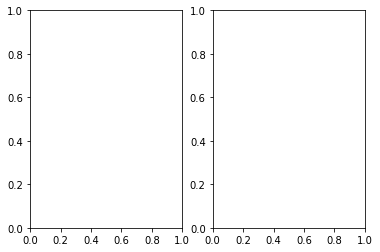

In [ ]:
fig, ax = plt.subplots(1, 2)

plt.plot(data['ID'].tail(10).values,data['LIMIT_BAL'].tail(10), 'b',ax=ax[0,0]) #row=0, col=0
ax[0, 0].xlabel('Recent Customer ID', fontsize=14)
ax[0, 0].ylabel('Credit Amount', fontsize=14)

ax[0, 1].plot(data['ID'].tail(10).values,data['default.payment.next.month'].tail(10), 'b') #row=0, col=0
ax[0, 1].xlabel('Recent Customer ID', fontsize=14)
ax[0, 1].ylabel('Defaulter(1) or Paid(0)', fontsize=14)

plt.show()